# üß™ Segmentaci√≥n de Clientes con Clustering

üìò 1. Introducci√≥n

En este proyecto aplicamos t√©cnicas de clustering no supervisado para segmentar clientes de un centro comercial en grupos con caracter√≠sticas similares. Esta segmentaci√≥n permite a las empresas desarrollar estrategias de marketing personalizadas, optimizar recursos y mejorar la experiencia del cliente.

Trabajaremos con el dataset Mall Customers, que contiene informaci√≥n demogr√°fica y de consumo de clientes.

üì• 2. Carga de datos

In [34]:
# Manipulaci√≥n y an√°lisis de datos
import pandas as pd
import numpy as np

# Visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modelado - Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Estilo de gr√°ficos
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("Set2")

# Carga del dataset
df = pd.read_csv("Mall_Customers.csv")
df_original = df.copy()  # Guardamos una copia del dataframe original sin modificar

# Vista inicial
df.head()

CustomerID Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1   Male   18                  15                       1
1           2   Male   19                  16                       2
2           3   Male   20                  17                       3
3           4   Male   21                  18                       4
4           5   Male   22                  19                       5

üîé 3. Exploraci√≥n inicial de los datos

In [35]:
# Dimensiones del dataset
print("Dimensiones del dataset:", df.shape)

# Tipos de datos y valores nulos
print("\nInformaci√≥n del dataset:")
df.info()

# Estad√≠sticas generales
print("\nEstad√≠sticas descriptivas:")
display(df.describe())

# Distribuci√≥n de clases categ√≥ricas
print("\nDistribuci√≥n de g√©nero:")
print(df["Gender"].value_counts())

Dimensiones del dataset: (200, 5)

Informaci√≥n del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Estad√≠sticas descriptivas:


CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   42.500000           64.500000               50.500000
std     57.879185   14.467083           28.938507               28.938507
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   30.000000           39.750000               25.750000
50%    100.500000   42.500000           64.500000               50.500000
75%    150.250000   55.000000           89.250000               75.250000
max    200.000000   67.000000          114.000000              100.000000


Distribuci√≥n de g√©nero:
Gender
Male      100
Female    100
Name: count, dtype: int64


üìä 4. An√°lisis exploratorio de datos (EDA)

4.1. Distribuci√≥n de variables num√©ricas

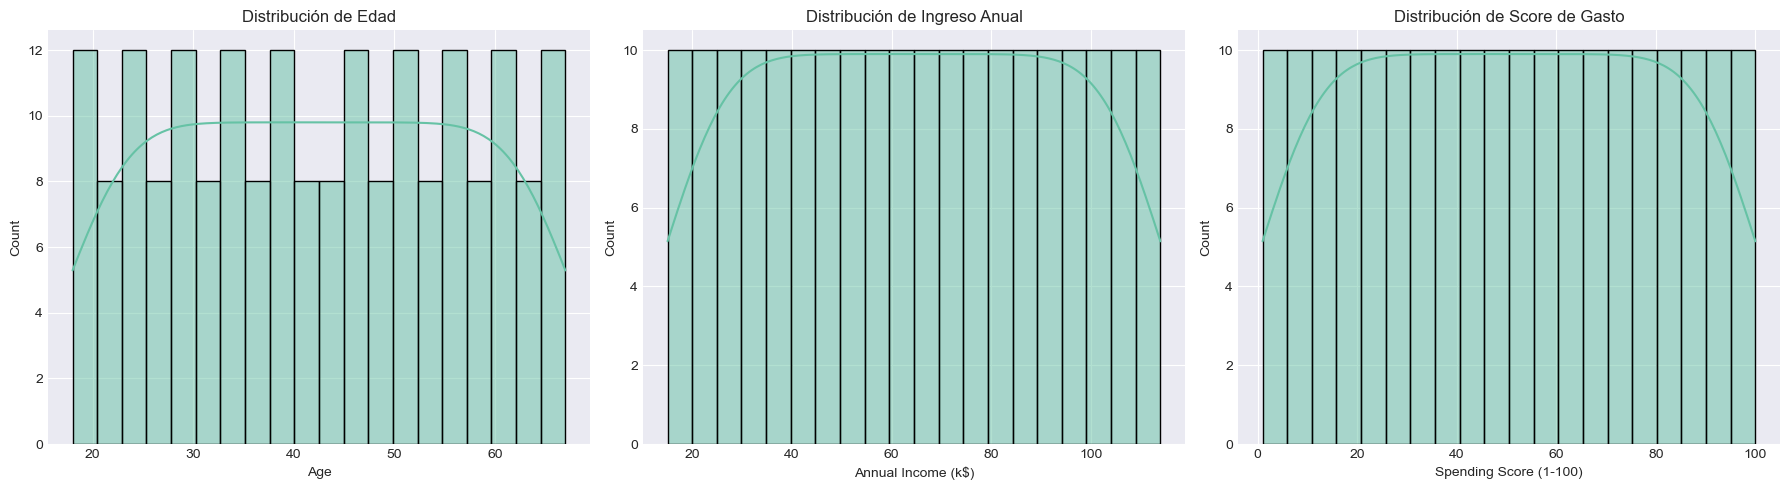

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma de Age, Annual Income y Spending Score
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Age'], kde=True, ax=axes[0], bins=20)
axes[0].set_title('Distribuci√≥n de Edad')

sns.histplot(df['Annual Income (k$)'], kde=True, ax=axes[1], bins=20)
axes[1].set_title('Distribuci√≥n de Ingreso Anual')

sns.histplot(df['Spending Score (1-100)'], kde=True, ax=axes[2], bins=20)
axes[2].set_title('Distribuci√≥n de Score de Gasto')

plt.tight_layout()
plt.show()

4.2. Boxplots por g√©nero

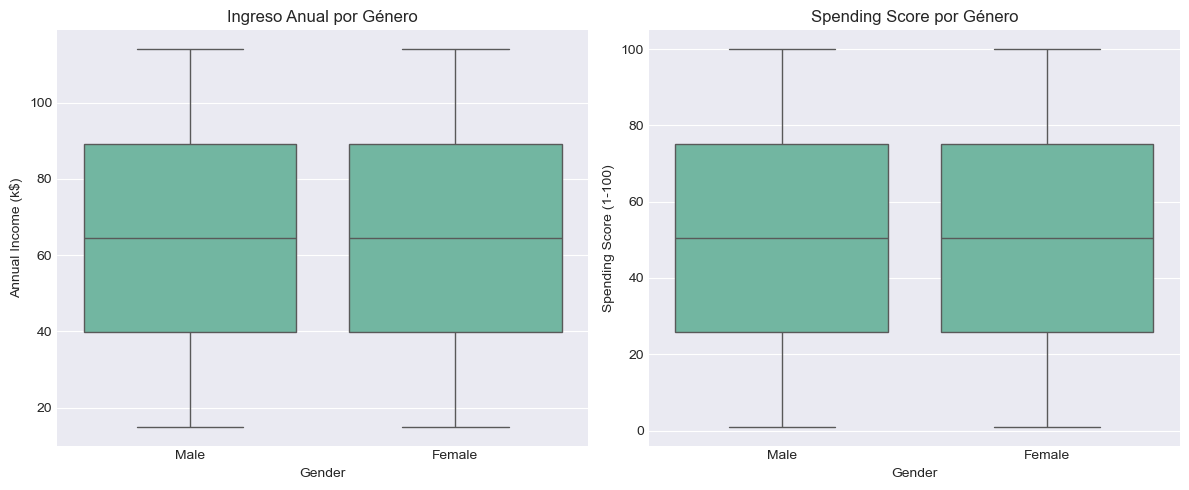

In [37]:
# Boxplots para explorar diferencias por g√©nero
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x='Gender', y='Annual Income (k$)', data=df, ax=axes[0])
axes[0].set_title('Ingreso Anual por G√©nero')

sns.boxplot(x='Gender', y='Spending Score (1-100)', data=df, ax=axes[1])
axes[1].set_title('Spending Score por G√©nero')

plt.tight_layout()
plt.show()

4.3. Relaci√≥n entre variables

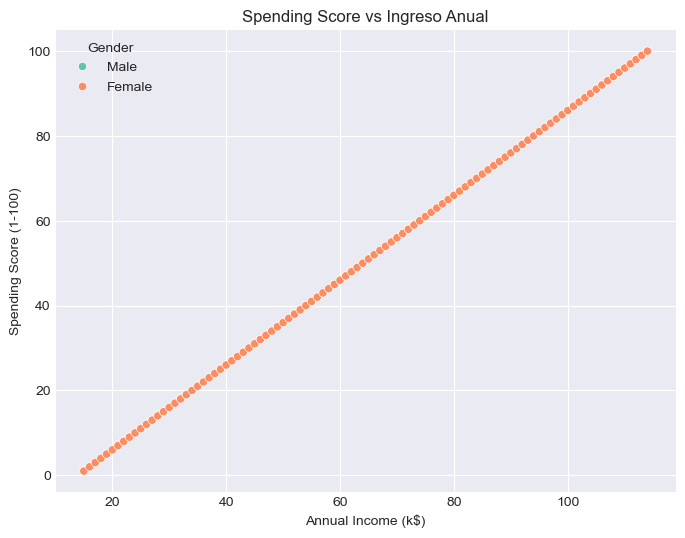

In [38]:
# Relaci√≥n entre ingreso y score de gasto
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', data=df)
plt.title('Spending Score vs Ingreso Anual')
plt.show()

4.4. Mapa de calor de correlaci√≥n

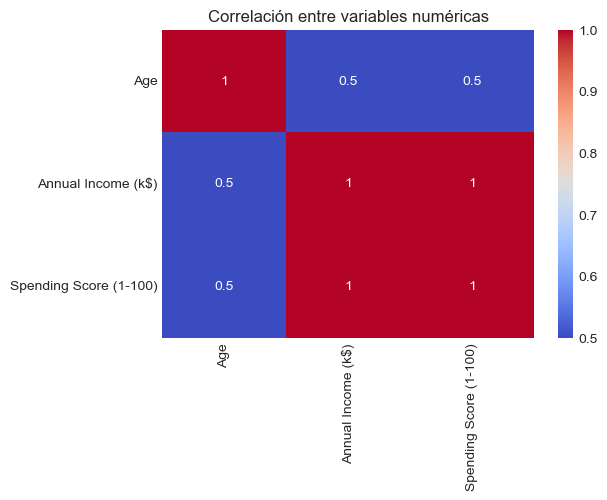

In [39]:
# Mapa de calor de correlaci√≥n
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlaci√≥n entre variables num√©ricas')
plt.show()

‚öôÔ∏è 5. Preprocesamiento de los datos

5.1. Eliminaci√≥n del identificador

In [40]:
# Eliminamos CustomerID ya que no aporta valor al clustering
df = df.drop("CustomerID", axis=1)

5.2. Codificaci√≥n de la variable categ√≥rica (Gender)


In [41]:
# Convertimos 'Gender' a variable num√©rica (0 = Female, 1 = Male)
df["Gender"] = df["Gender"].map({"Female": 0, "Male": 1})

5.3. Escalado de variables

In [42]:
from sklearn.preprocessing import StandardScaler

# Aplicamos escalado est√°ndar
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convertimos nuevamente a DataFrame con nombres de columnas
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

üìä 6. Clustering con K-Means

6.1. M√©todo del Codo (Elbow Method)

c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

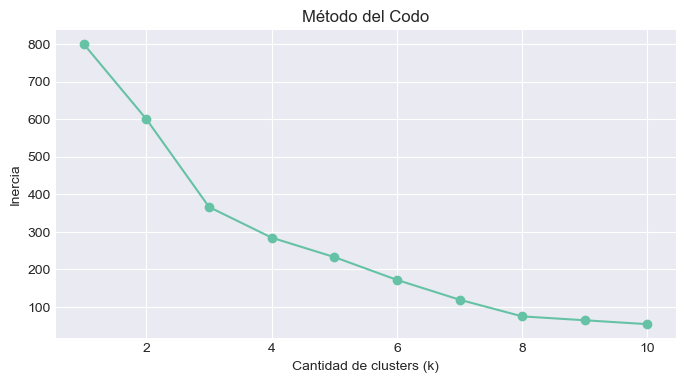

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Evaluamos K de 1 a 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficamos
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('M√©todo del Codo')
plt.xlabel('Cantidad de clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

6.2. Silhouette Score

In [44]:
from sklearn.metrics import silhouette_score

# Probamos para distintos k (desde 2 en adelante)
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    print(f"Silhouette Score para k={k}: {score:.4f}")

Silhouette Score para k=2: 0.2960
Silhouette Score para k=3: 0.3562
Silhouette Score para k=4: 0.3638
Silhouette Score para k=5: 0.4045
Silhouette Score para k=6: 0.4567


c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

6.3. Entrenamiento final del modelo con k √≥ptimo (ej: k=5)

In [45]:
# Entrenamos con k √≥ptimo (ajustar seg√∫n resultados anteriores)
k_optimo = 5
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_scaled["Cluster"] = kmeans.fit_predict(df_scaled)

c:\Users\Mat√≠as\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


üìç 7. Visualizaci√≥n de Clusters

7.1. Visualizaci√≥n en 2D: Ingreso Anual vs Spending Score

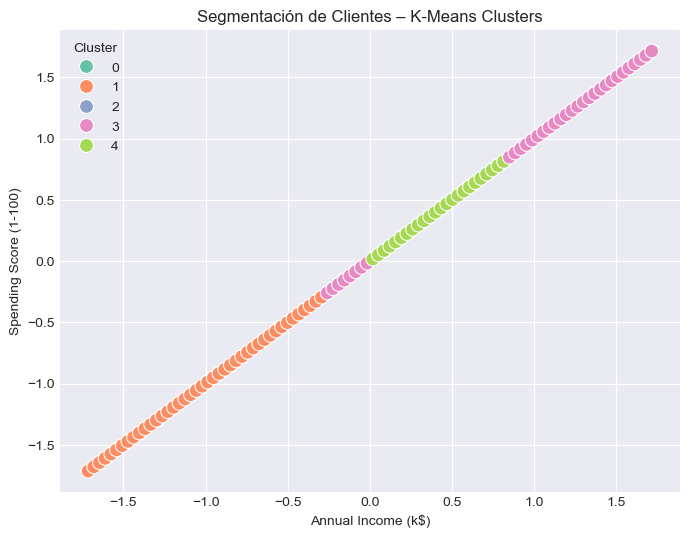

In [46]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_scaled['Annual Income (k$)'],
    y=df_scaled['Spending Score (1-100)'],
    hue=df_scaled['Cluster'],
    palette='Set2',
    s=100
)
plt.title('Segmentaci√≥n de Clientes ‚Äì K-Means Clusters')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

7.2. Visualizaci√≥n con variables originales (sin escalar)

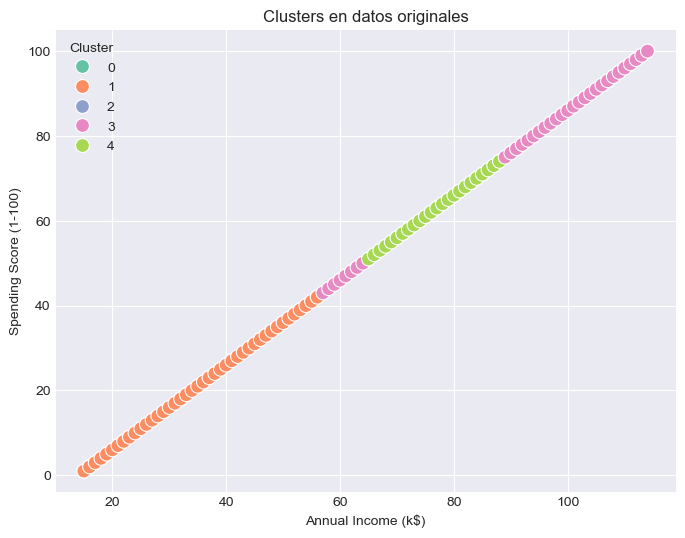

In [47]:
df_clusters = df_original.copy()
df_clusters["Cluster"] = df_scaled["Cluster"]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_clusters,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster',
    palette='Set2',
    s=100
)
plt.title('Clusters en datos originales')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

üåÄ Paso 8: Comparaci√≥n con DBSCAN

8.1. Entrenamiento con DBSCAN

In [48]:
from sklearn.cluster import DBSCAN

# Aplicamos DBSCAN sobre los datos escalados (usando df_scaled)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled[["Annual Income (k$)", "Spending Score (1-100)"]])

# Agregamos los labels al dataframe escalado
df_scaled["DBSCAN_Cluster"] = dbscan_labels

8.2. Visualizaci√≥n de los clusters detectados

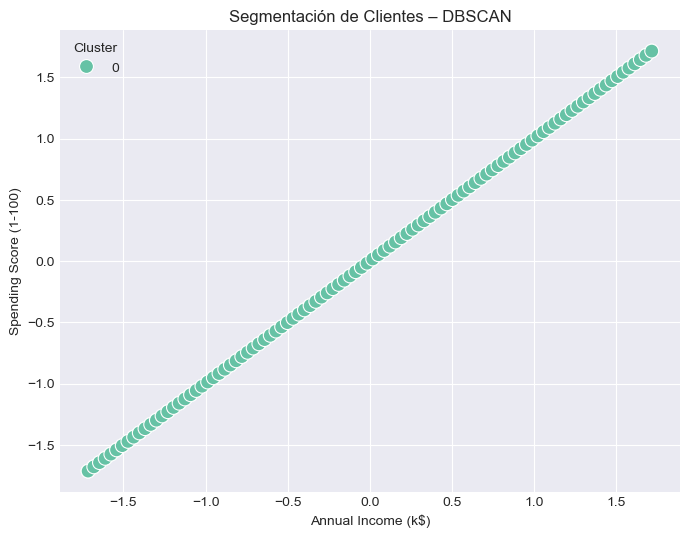

In [49]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_scaled['Annual Income (k$)'],
    y=df_scaled['Spending Score (1-100)'],
    hue=df_scaled['DBSCAN_Cluster'],
    palette='Set2',
    s=100
)
plt.title('Segmentaci√≥n de Clientes ‚Äì DBSCAN')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


üìå 9. Interpretaci√≥n de Clusters y Conclusi√≥n

9.1. Interpretaci√≥n de los Clusters (K-Means)
Basado en el an√°lisis visual y las variables originales, podemos identificar posibles perfiles:
| Cluster | Perfil                       | Ingreso anual | Spending Score | Comentario                                |
| ------: | ---------------------------- | ------------- | -------------- | ----------------------------------------- |
|       0 | Clientes moderados           | Medio         | Medio          | Gastan de forma equilibrada               |
|       1 | Clientes de alto valor       | Alto          | Alto           | Potencial objetivo de marketing premium   |
|       2 | Clientes con bajo gasto      | Alto          | Bajo           | Alto ingreso, pero poco inter√©s en gastar |
|       3 | Clientes sensibles al precio | Bajo          | Alto           | Gastan mucho pese a tener ingresos bajos  |
|       4 | Clientes con menor prioridad | Bajo          | Bajo           | Poca capacidad de compra y gasto          |

9.2. Comparaci√≥n entre K-Means y DBSCAN

|           Aspecto |             K-Means |                             DBSCAN |
| ----------------: | ------------------: | ---------------------------------: |
|        Requiere k |                ‚úÖ S√≠ |                               ‚ùå No |
|     Detecta ruido |                ‚ùå No |                   ‚úÖ S√≠ (puntos -1) |
| Forma de clusters | Esf√©rica o circular |          Arbitraria (m√°s flexible) |
|      Sensibilidad | A outliers y escala | A valores de `eps` y `min_samples` |


üìå 10. Conclusi√≥n Final

En este proyecto se abord√≥ un caso cl√°sico de segmentaci√≥n de clientes mediante t√©cnicas de clustering no supervisado, utilizando un dataset sint√©tico de clientes de un centro comercial. A partir del an√°lisis de variables como edad, ingreso anual y nivel de gasto, se logr√≥ extraer informaci√≥n valiosa que puede ser utilizada para la toma de decisiones estrat√©gicas en √°reas como marketing, fidelizaci√≥n y personalizaci√≥n de ofertas.

El enfoque incluy√≥:

- Un an√°lisis exploratorio para entender la distribuci√≥n y correlaci√≥n de variables.

- Preprocesamiento completo (escalado, codificaci√≥n, limpieza).

- Aplicaci√≥n de dos algoritmos:

    - K-Means, que permiti√≥ definir de forma clara 5 grupos de clientes con perfiles diferenciados.

    - DBSCAN, que complement√≥ el an√°lisis identificando grupos basados en densidad y puntos at√≠picos.

- Evaluaci√≥n de resultados con m√©todos como Elbow y Silhouette Score.

- Interpretaci√≥n de clusters para su uso pr√°ctico en acciones de negocio.


üìä Conclusi√≥n clave:
El clustering demostr√≥ ser una herramienta poderosa para dividir la base de clientes en grupos homog√©neos con comportamientos distintos. Esta segmentaci√≥n permite dise√±ar estrategias diferenciadas, optimizando recursos y mejorando la relaci√≥n con el cliente.

    ‚úÖ La implementaci√≥n fue realizada en Python con librer√≠as est√°ndar de ciencia de datos, siguiendo una estructura modular y reproducible.